# Introduction

- Trong bài này, chúng ta mong muốn có thể tạo caption cho bức ảnh. Chúng ta sẽ code từ đầu cho bài này nhé !

- Đầu tiên chúng ta cần phải chuẩn bị data. Bạn hãy click vào [data](https://drive.google.com/file/d/1CP8Pw-syl2KWvpV0xyhkAMa7zre6dCBY/view), sau đó hãy thêm file `archive.zip` vào drive của mình nhé ! Tập data này được public trên kaggle, các bạn có thể xem thêm thông tin về tập data này ở trang chủ cuộc thi [kaggle](https://www.kaggle.com/adityajn105/flickr8k).

- Trong bài này, mình code dựa trên bài viết chi tiết này [link](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning), mọi người hãy click vào và đọc `readme` nhé ! 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


In [2]:
# unzip file archive.zip 
import os
if not os.path.isdir('/content/drive/MyDrive/flickr8k'):
  !unzip archive.zip 

- Hãy dành thời gian để quan sát data nhé, có khoảng 8k ảnh trong thư mục `flickr8k/images`. Mỗi bức ảnh sẽ có 5 captions, tất cả được lưu ở file `flickr8k/captions.txt`. Các bạn chú ý file này có nội dung như thế nào nhé

# 1. Utils

In [3]:
# một số config nhé
img_folder = 'flickr8k/images'  # folder chứa các ảnh
stoi_file = 'flickr8k/stoi.json' # sequence to index trong phần encode
itos_file = 'flickr8k/itos.json' # index to sequence để tiện decode
model_save_path = 'flickr8k/model.pth' # lưu lại trained model ở file này
grad_clip = 5 # tham số liên quan đến clip gradients
freq_threshold = 3 # tham số liên quan đến stop words

In [4]:
import glob
import json
from sklearn import model_selection
import spacy  # for tokenizer
spacy_eng = spacy.load("en_core_web_sm")
import torch
import torchvision

- Trong phần này, chúng ta cần viết một số hàm/class sau :

  - `make_data` đầu vào là file captions.txt, chúng ta cần trả về  `img_names` (list các tên ảnh) và `captions` (list các captions) 

  - `split_data` đầu vào là `img_paths` và `targets`, trả về  `img_names_train,captions_train,img_names_val,captions_val,img_names_test,captions_test`, tỷ lệ test_size có thể để 0.05

  - `write_json` và `read_json` để tiện làm việc với json file
  - Class `Vocab` với 2 thuộc tính quan trọng là `ios` và `soi`
  - `tokenizer_eng` để  token text 
  - `numericalize` encode một text dựa vào `soi` 
  - `save_checkpoint` lưu lại model 


In [5]:
def make_data(txt_path = 'flickr8k/captions.txt'):
    img_names = []
    captions = []
    with open(txt_path,'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            line = line.split(',')
            img_names.append(line[0])
            captions.append(','.join(line[1:])[:-1])
    return img_names,captions


def split_data(img_paths,targets):
    img_names_train, img_names_test, captions_train, captions_test = model_selection.train_test_split(img_paths, targets, test_size=0.05, random_state=1)
    img_names_train, img_names_val, captions_train, captions_val = model_selection.train_test_split(img_names_train, captions_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2
    return img_names_train,captions_train,img_names_val,captions_val,img_names_test,captions_test


def write_json(data,data_path):
    with open(data_path,'w') as f:
        json.dump(data,f,indent=4)


def read_json(data_path):
    with open(data_path,'r') as f:
        data = json.load(f)
    return data


class Vocab:

    def __init__(self,captions,freq_threshold):
        self.captions = captions
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def get_vocab(self):
        word2fre ={}
        idx = 4 # >3!
        self.max_length = 0
        for caption in self.captions:
            for i,word in enumerate(tokenizer_eng(caption)):
                if word not in word2fre:
                    word2fre[word] = 1
                else:
                    word2fre[word]+=1
                if word2fre[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

            if i + 1 > self.max_length:
                self.max_length = i + 1


def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]


def numericalize(text,stoi):
    tokenized_text = tokenizer_eng(text)

    return [
        stoi[token] if token in stoi else stoi["<UNK>"]
        for token in tokenized_text
    ]


def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer,model_save_path='flickr8k/model.pth'):
  
    state = {'epoch': epoch,       
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = model_save_path + '.tar'
    torch.save(state, filename)
   


In [6]:
img_paths = glob.glob(os.path.join(img_folder,'*.jpg'))
assert len(img_paths) == 8091 # số ảnh

In [7]:
img_names,captions = make_data()
img_names_train,captions_train,img_names_val,captions_val,img_names_test,captions_test = split_data(img_names,captions)

In [ ]:
vocab = Vocab(captions_train,freq_threshold)
vocab.get_vocab()
write_json(vocab.itos,itos_file)
write_json(vocab.stoi,stoi_file)
assert vocab.max_length == 42
stoi = read_json(stoi_file)
assert len(stoi) == 3576
print(numericalize('Hello there, I am Manh',stoi))

# 2. Dataloader

- Tiếp theo chúng ta sẽ xây dựng một custom dataset trong torch nhé ! 
  - Chúng ta cần chú ý vào hàm `__getitem__(idx)`, trả về một sample có index là `idx` trong dataset chứa ảnh đã qua tiền xử lý, caption đã được encode, chiều dài caption, và tên ảnh(không quan trọng trong bài này)
  - Ngoài ra cần viết thêm `__len__` trả về số samples

In [9]:
# Set một số hyperpara cần thiết nhé
batch_size = 4
num_workers = 4
max_len = 45

In [10]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import cv2


class IMDataset(Dataset):

    def __init__(self, img_names, captions,transform=None):
        self.img_names = img_names
        self.captions = captions
        self.transform = transform
        self.itos = read_json(itos_file)
        self.stoi = read_json(stoi_file)     

    def __len__(self):
        return len(self.img_names)

    def encode(self,c):
        c = numericalize(c,self.stoi)
        self.c_len = len(c)
        enc = [1] + c + [2] + [0] * (max_len - len(c))
        return enc

    def __getitem__(self, index):
        caption = self.captions[index]
        img_name = self.img_names[index]
        img = cv2.imread(os.path.join(img_folder, img_name))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(256,256))
        img = torch.FloatTensor(img/255)
        img = img.permute(2,0,1)
        if self.transform is not None:
            img = self.transform(img)
        enc = self.encode(caption)
        caplen = self.c_len + 2
        return img, torch.LongTensor(enc),torch.LongTensor([caplen]),img_name

In [48]:
import random 
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
        [transforms.Resize((224, 224))]
)

dataset = IMDataset(img_names_test,captions_test, transform=transform)
pad_idx = dataset.stoi["<PAD>"]
itos = dataset.itos
loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
)

imgs, captions,_,_ =  iter(loader).next()
print(imgs.shape)

torch.Size([4, 3, 224, 224])


a white dog is running through the water onto the shore .


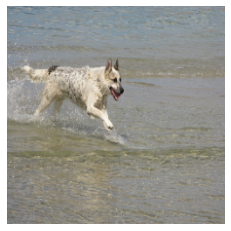

In [49]:
def plot(imgs,captions):
  idx = random.choice(range(len(imgs)))
  img = imgs[idx]
  caption = captions[idx].detach().cpu().numpy()
  caption = ' '.join([itos[str(x)] for x in caption if x!=0 and x!=1 and x!=2])
  img = img.permute(1,2,0).detach().cpu().numpy()
  plt.axis('off')
  plt.imshow(img)
  print(caption)
  plt.show()

plot(imgs,captions)

# 3. Model

- Chúng ta sẽ implement model có kiến trúc như sau : 

  - Trong phần encoder, chúng ta finetune resnet101 một chút, dùng để encode ảnh
  - Phần decoder sẽ sử dụng cơ chế attention, nhưng phần nào quan trọng trên bức ảnh sẽ được đánh trọng số cao hơn trong quá trình học. Ngoài ra phần decoder sẽ có 2 thứ quan trọng nữa là Embedding và LSTM. 

![](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/img/model.png?raw=true)


## 3.1 Encoder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size
        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        #chúng ta không cần sử dụng 2 layers cuối của resnet101
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):  # images có shape (batch_size, 3, image_size, image_size)
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

## 3.2 Decoder

In [13]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


In [14]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  
    def init_weights(self):
        """
        Khởi tạo một số tham số với giá trị trong phân bố uniform giúp hội tụ dễ hơn
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Hàm này load pretrained embeddings(input) 
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Bạn có finetune pretrained embedding không!
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Tạo initial hidden và cell states cho decoder's LSTM dựa trên ảnh đã encode. Trả về hidden state & cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sắp xếp lại input data theo chiều giảm dần lengths
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # khởi tạo LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # chúng ta không cần decode vị trí cuối cùng (<end>) nên có thể kết thức quá trình decode ở đây, `decoding_lengths` sẽ là `caption_lengths - 1)`
        decode_lengths = (caption_lengths - 1).tolist()

        # Tạo tensor để lưu lại word predicion scores và alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # Ở mỗi timestep, chúng ta tạo ra từ mới dựa trên attention weight(dựa vào ) và từ trước đó
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths]) 
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

# 4. Train

In [22]:
alpha_c = 1
encoder_lr = 1e-4  
decoder_lr = 4e-4 
num_epochs = 10

# Một số hyperpara quan trọng của model
emb_dim = 512  # dimension của word embeddings
attention_dim = 512  # dimension của attention linear layers
decoder_dim = 512  # dimension của decoder RNN
dropout = 0.5

save_log = "flickr8k/log.csv"


In [198]:
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import torch.nn.functional as F

def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
  
    decoder.train() 
    encoder.train()
    losses = 0
    for imgs, caps, caplens,_ in tqdm(train_loader):      
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:] # không tính token đầu (<start>)

        # Sử dụng pack_padded_sequence để  remove timesteps mà chúng ta không cần decode đến(thừa), hoặc pad nếu còn thiếu
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
        loss = criterion(scores.data, targets.data)
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        losses += loss.item()

        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
    return losses


def validate(val_loader, encoder, decoder, criterion,is_training=True):
    decoder.eval()  
    if encoder is not None:
        encoder.eval()
    losses = 0
    with torch.no_grad():
      if is_training:
        for imgs, caps, caplens,_ in tqdm(val_loader):
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            if encoder is not None:
                encoded_imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encoded_imgs, caps, caplens)
            targets = caps_sorted[:, 1:] 
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
            loss = criterion(scores.data, targets.data)
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            losses += loss.item()
            return losses
      else:
            imgs, caps, caplens,_ = iter(val_loader).next()
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            if encoder is not None:
                encoded_imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encoded_imgs, caps, caplens)
            targets = caps_sorted[:, 1:] 
            scores_copy = scores.clone()
            scores = F.log_softmax(scores_copy.data,dim=2)
            scores = scores.argmax(dim=2,keepdim=True)
            plot(imgs,torch.squeeze(scores,dim=2))

In [199]:
def trainer(is_train=True):    

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose(
        [
            #transforms.RandomCrop((224, 224)),
            normalize,
        ]
    )
    stoi = read_json(stoi_file)
    pad_idx = stoi["<PAD>"]
    train_dataset = IMDataset(img_names_train, captions_train, transform=transform)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers
    )

    val_dataset = IMDataset(img_names_val, captions_val, transform=transform)

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers
    )

    test_dataset = IMDataset(img_names_test, captions_test, transform=transform)

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers
    )

    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(stoi),
                                       dropout= dropout)
    
    encoder = Encoder()
    fine_tune_encoder = False
    encoder.fine_tune(fine_tune_encoder)

    decoder = decoder.to(device)
    encoder = encoder.to(device)

    try:
      checkpoint = torch.load(model_save_path+'.tar')
      decoder = checkpoint['decoder']
      encoder = checkpoint['encoder']
    except:
      pass

    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    criterion = nn.CrossEntropyLoss().to(device)
    best_loss_val = 99999
    log = []
    if is_train:
      for epoch in range(num_epochs + 1):
          train_loss = train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
          val_loss = validate(val_loader, encoder, decoder, criterion)
          log_epoch = {"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss}
          log.append(log_epoch)
          df = pd.DataFrame(log)
          df.to_csv(save_log)
          if val_loss < best_loss_val:
              best_loss_val = val_loss
              save_checkpoint(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer)
          print("Epoch {} || epoch_train_loss: {:.4f} || Epoch_val_loss: {:.4f} ".format(epoch + 1, train_loss, val_loss))
    else:
        validate(train_loader, encoder, decoder, criterion,is_training=is_train)

In [200]:
# trainer() # Bỏ comment để train

# 5. Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man in a red shirt is a <UNK> . a wooden wall .


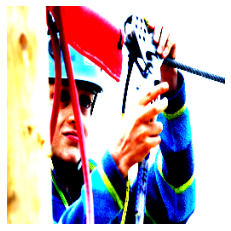

In [201]:
trainer(is_train = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a people are riding a line . in


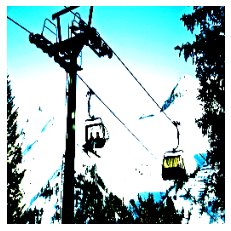

In [211]:
trainer(is_train = False)